# fSIM speckle processing code

In [1]:
# Import packages

%matplotlib inline
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import h5py

plt.style.use(['dark_background'])


/home/lihao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Arrayfire implementation

import arrayfire as af
from fSIM_2D_func.fSIM_2D_func_af import *

af.set_backend('cuda')
af.set_device(2)
af.device_info()

### If no arrayfire, please import the following instead:
# from fSIM_2D_func.fSIM_2D_func import *

{'device': 'GeForce_GTX_1080_Ti',
 'backend': 'CUDA',
 'toolkit': 'v8',
 'compute': '6.1'}

In [3]:
### Load data

Ic_image = np.transpose(h5py.File('../calibrated_coherent_data.mat')['Ic_image'][:],(0,1,3,2))
I_image = np.transpose(h5py.File('../calibrated_fluorescent_data.mat')['I_image'][:],(0,2,1))



In [4]:
# Experimental parameters

lambda_f      = 0.605             # fluorescence wavelength
mag           = 5                 # system magnification
pscrop        = 5.5/mag           # effective pixel size on camera plane
NA_obj        = 0.1               # Objective NA
NAs           = 0.3               # speckle NA
bg            = 0                 # background noise
upsamp_factor = 4                 # upsampling factor (should upsample to Nyquist of expected resolution)



In [5]:
# Upsampling image

I_image_up = image_upsampling(I_image, upsamp_factor, bg)


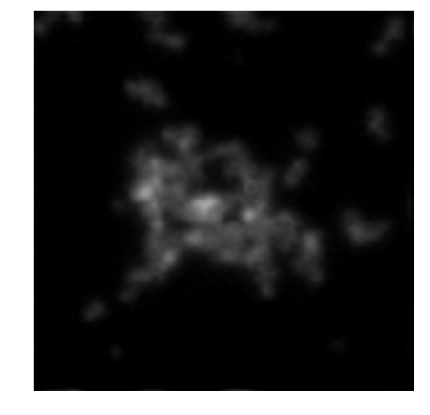

In [6]:
display_image_movie(I_image_up, frame_num=5, size=(7,7), pause_time=0.0001)

Text(0,0.5,'yshift (px)')

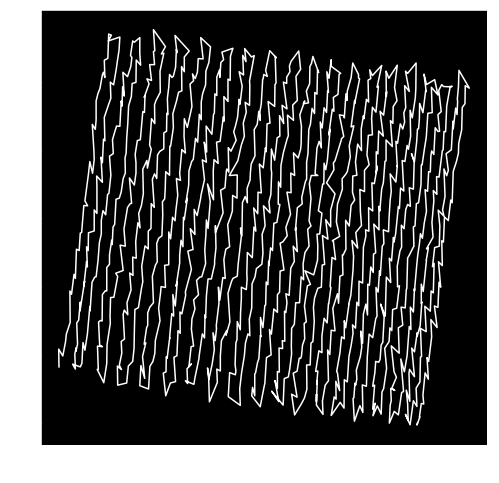

In [7]:
# Image registration to get shift
xshift, yshift = image_registration(Ic_image[0], 100, upsamp_factor)

plt.figure(figsize=(8,8))
plt.plot(xshift,yshift,'w')
plt.axis('equal')
plt.xlabel('xshift (px)')
plt.ylabel('yshift (px)')

In [8]:
# Initialize the solver object

fSIM_sol = fSIM_2D_solver(I_image_up, xshift, yshift, 80, lambda_f,\
                       pscrop, upsamp_factor, NA_obj, NAs, 10)


|  10  |  6.66e+08  |   155.10   |


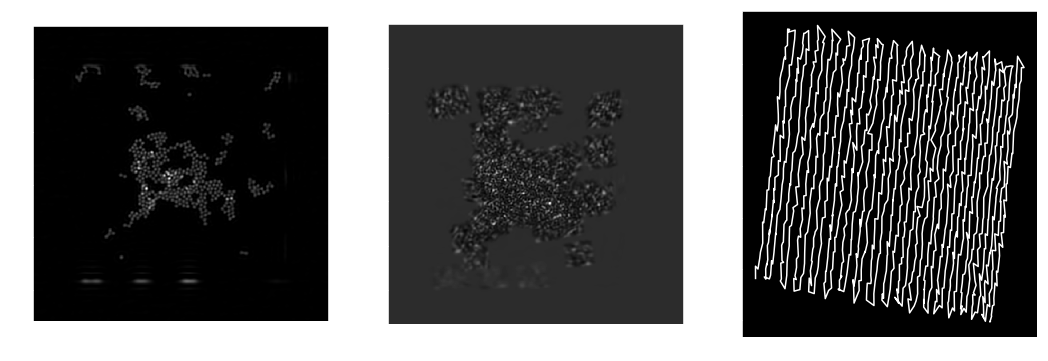

In [9]:
# Run the iterative algorithm
figsize = (18,6)
fSIM_sol.iterative_algorithm(I_image_up, 1, 1e3, 1, 1/12, figsize)

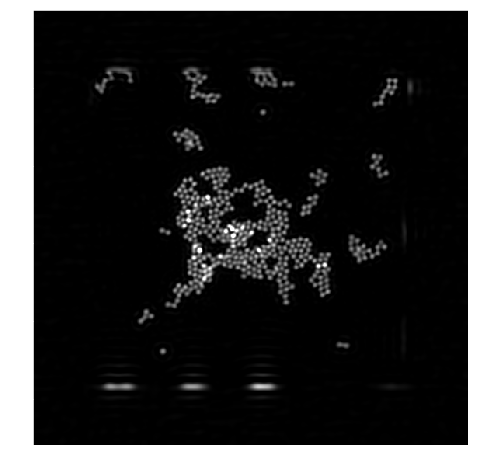

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(np.maximum(0,fSIM_sol.I_obj), cmap='gray', clim=(0, np.max(fSIM_sol.I_obj)/2))